### Presentación del proyecto

##**Objetivo**

Los aerolíneas juegan un rol muy importante en los movimientos de viaje y relaciones a nivel global, tanto por motivos laborales o de ocio.

Las reseñas de éstas, se convirtieron en un estándar para orientar a los usuarios en la comparación al momento de elegir. Pero además, permiten a las aerolíneas, obtener un insight sobre la experiencia de los pasajeros, sus preferencias y el nivel de satisfacción en cada caso.
<br><br>


Con el acceso a herramientas e información que poseemos hoy en día, podemos categorizar miles de reseñas en etiquetas de sentimiento positivo, negativo, o neutral.

El objetivo es trabajar este conjunto de datos con reseñas en texto de diversos hoteles, junto a una calificación de 1 a 5 (1 siendo muy negativo y 5 siendo muy positivo). A partir de esta clasificación, al obtener una reseña nueva, se puede predecir si ésta es positiva o negativa.

###Contenido del dataset

####Columnas

**Airline Name** = Nombre de la Aerolínea

**Overall Rating** = Calificación total

**Review Title** = Titulo de la reseña

**Review Date** = Fecha de la reseña

**Verified** = Si la reseña está verificada o no

**Review** = Texto de la reseña

**Aircraft** = Tipo de avión

**Type of Traveller** = Tipo de pasajero

**Seat Type** = Tipo de asiento

**Route** = Ruta de viaje

**Date Flown** = Fecha de vuelo

**Seat Comfort** = Calificación de comodidad del asiento

**Cabin Staff Service** = Calificación del staff de cabina

**Food & Beverages** = Calificación de la comida y bebida

**Ground Service** = Calificación del servicio en tierra

**Inflight Entertainment** = Calificación del entretenimiento en el vuelo

**Wifi & Connectivity** = Calificación de WiFi y conectividad

**Value for Money** = Calificación de relación precio/calidad

**Recommended** = Recomendado si/no


####Citaciones

Recopilación por Juhi Bhojani y subido en Kaggle y Github

https://www.kaggle.com/datasets/juhibhojani/airline-reviews

https://github.com/Juhibhojani/Airline-Reviews-

Las reviews de aerolíneas de este dataset fueron obtenidas por el autor desde:

https://www.airlinequality.com/review-pages/a-z-airline-reviews/

### **Lectura de datos**

**Librerias necesarias**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
import re

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

import spacy

#TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

from textblob import TextBlob

#NLTK
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.util import ngrams
import string

nltk.download('punkt')  # Tokenizers
nltk.download('punkt_tab')
nltk.download('stopwords')  # Stop words
nltk.download('wordnet')  # WordNet lemmatizer
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [2]:
url = "https://raw.githubusercontent.com/Larrentawn/NLP-project/refs/heads/main/Airline_review.csv"
df = pd.read_csv(url, sep=",")

In [3]:
nlp = spacy.load("en_core_web_sm")

##**Análisis inicial**

In [4]:
df.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


Podemos observar algunos de los valores que tenemos en el dataset, asi como sus columnas. Algo que podemos ver a simple vista es que las fechas estan en formato escrito.

In [5]:
df.shape

(23171, 20)

In [6]:
df.describe()

,Unnamed: 0,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money
count,23171.00000,19016.000000,18911.000000,14500.000000,18378.000000,10829.000000,5920.000000,22105.000000
mean,11585.00000,2.618374,2.871609,2.553586,2.353738,2.179056,1.780405,2.451165
std,6689.03588,1.464840,1.604631,1.526314,1.595747,1.488839,1.318800,1.594155
min,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,5792.50000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,11585.00000,3.000000,3.000000,2.000000,1.000000,2.000000,1.000000,2.000000
75%,17377.50000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,4.000000
max,23170.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Vemos datos como la media y la desviación estandar.

In [7]:
df.dtypes

,0
Unnamed: 0,int64
Airline Name,object
Overall_Rating,object
Review_Title,object
Review Date,object
Verified,bool
Review,object
Aircraft,object
Type Of Traveller,object
Seat Type,object


Podemos ver varias cosas, los nombres de las columnas tienen mayúsculas, símbolos y espacios.

La columna **Overall Rating** es de tipo **object** en lugar de **int** o **float** y los de columna temporal que nos interesa **(Review Date)** es también de tipo object en lugar de **datetime**. También la variable de **Recommended** que es si/no.

In [8]:
pd.set_option('display.max_colwidth', None) #Visualizar el total del texto en la columna
df.describe(include="O").T

,count,unique,top,freq
Airline Name,23171,497,Aegean Airlines,100
Overall_Rating,23171,10,1,11595
Review_Title,23171,17219,Onur Air customer review,84
Review Date,23171,4557,16th July 2023,67
Review,23171,23046,I flew Lan Peru on a domestic flight from Lima to Cusco in August 2001. I selected Lan Peru because if its affiliation with Lan Chile and subsequent affiliation with the OneWorld frequent flyer alliance. Check in at Lima's Jorge Chavez International Airport was a bit chaotic and rushed. This was the first Lan Peru (flt. 93) flight of the day and surprisingly the check in counters opened a mere 45 minutes before the flight was to depart. We departed on time for the 1 hour flight and inflight service was hospitable and efficient. The bilingual cabin crew came through with a continental breakfast and drinks. Lan Peru does not have an inflight magazine though so if you want to read something inflight bring your own materials. The morning return flight one week later (flt. 93) was much the same. Both flights arrived about 5 minutes early. On the outbound flight between Lima and Cuzco it is suggested that one sit on the left side of the plane and on the return on the right side. This gives one the opportunity to see spectacular views of the snow capped Andes. Overall Lan Peru's service was efficient friendly and recommended.,2
Aircraft,7129,1048,A320,1041
Type Of Traveller,19433,4,Solo Leisure,7120
Seat Type,22075,4,Economy Class,19145
Route,19343,13607,Melbourne to Sydney,43
Date Flown,19417,109,June 2023,1057


Se puede ver más en profundidad las columnas de tipo **Object**, un conteo de valores unicos, el top y su frecuencia.

Vemos que las calificaciones **(overall_rating)** casi la mitad de los valores son 1, es decir posee muchisimas calificaciones negativas.

Las variables **type_of_traveller**, **seat_type** y **recommended** podrian ser codificadas en categorias numericas.
Tambien con la variable **overall_rating**.

Se procede a normalizar los nombres de las columnas

In [9]:
df.columns = [col.replace(" ", "_").lower() for col in df.columns]
df.dtypes

,0
unnamed:_0,int64
airline_name,object
overall_rating,object
review_title,object
review_date,object
verified,bool
review,object
aircraft,object
type_of_traveller,object
seat_type,object


In [10]:
df['overall_rating'].unique()

array(['9', '1', '8', '2', '3', '5', '6', '7', '4', 'n'], dtype=object)

En las calificaciones encontramos el valor 'n', el cual probablemente sea null.
Podemos ver un aproximado de donde podria ser alineada esta no-calificacion con algunos indicadores.


In [11]:
#Podemos leer algunas de las reseñas con este valor 'n'

df[df['overall_rating'] == 'n'][['review', 'overall_rating']].sample(5)

,review,overall_rating
16746,Sydney to Albury Staff at Check-in genuine warm and inviting. On time departure on small and very full plane no room for much baggage. Just over an hour flying time . One crew operation and I was looking forward to a bubbly friendly crew member however this Hostess was abrubt and rude. Most of the short flight she stood in the flightdeck with door wide open talking with the flight crew. A little girl sitting opposite me travelling alone ( 6yr old ) pressed the call light 3times to no avail of the hostess. This was my first experience with REX and maybe I should try again as most comments posted here are positive.,n
3661,NOU-NRT return. Almost new Airbus A330 good flight entertainment system but the crew wasn't nice and seem to be inexperienced and not very conscious about safety (customers walking in the cabin while the seatbelt sign was on). The meals were similar to low cost airlines and choice of drinks was also very poor. I wish I had the choice of another airlines between Noumea and Tokyo but unfortunately Air Calin is the only one on this destination.,n
16073,LGW-BKK-HKT return. As you can see we had two internal flights - to Phuket and back. Firstly I must agree with all other comments food good quick check in offered exit seats with legroom staff friendly but not very professional. Thai greeting towels ok toilets very clean and not very good in flight entertainment. Then it comes to the 8 hour delay at Bangkok( after a 12 hour flight) on our domestic flight to phuket. We roamed the airport aimlessly for 8 hours - not good. we were promised a transfer to Thai Airways which was not going to happen as the plane was full - bad news. Then they kept our cases at the desk and said they would be checked in for us ( along with seven other passengers cases) but when we got to Phuket we had no cases ( the other seven did) We waited until the next afternoon before they arrived at our hotel - which really meant we lost a whole day of doing nothing. It gets worse. We had to rearrange our Pick Ups at the airport. Then all this happened on the return flight from Phuket to Bankgkok. 4 hours delay. Also the food was cold on both domestic flights. The flight to LGW via Dubai was long and hot - we didn't just refuel - but off and onloaded cargo which took nearly two hours I'm sure. I timed the return flight - 15 hours 1am to 4pm. I would never use them for domestic flight ever again and only if I couldn't get another flight would I use them for international flight. Would not recommend.,n
2068,PEK-FNJ FNJ-SHE. Beijing to Pyongyang on Tupolev 154 very old plane revolutionary marching music played before take off and before landing. Attentive service meal on 1.5 hour flight - food a little processed but edible. Return to Shenyang on Ilyushin IL-18 - by far the oldest plane have flown on and was very happy to land! Food was a sandwich containing undentified meat but quite tasty. Both flights unique and a great way to start/finish a trip to North Korea.,n
11938,Kuwait - Beirut return with my family. Brand new aeroplanes with leather seats. Excellent service with comprehensive menu where you can order food drinks and snacks (cold food only). No alcohol airline. As a low cost carrier you pay for the food but the prices are reasonable. Return fare only KWD82 compared to KWD165 on MEA (both including taxes). No discount for children. Excellent on-time performance and no luggage problems. Highly recommended as a value for money carrier.,n


Tambien podemos ver si respondió si recomendaría o no la aerolinea

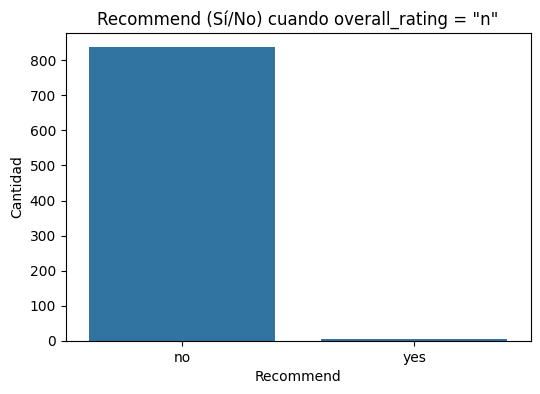

In [12]:
#Se filtra por respuesta 'n' en rating
df_overall_rating_n = df[df['overall_rating'] == 'n']

#Visualizacion de respuesta de recomienda si o no
plt.figure(figsize=(6,4))
sns.countplot(data=df_overall_rating_n, x='recommended')
plt.title('Recommend (Sí/No) cuando overall_rating = "n"')
plt.xlabel('Recommend')
plt.ylabel('Cantidad')
plt.show()


Vemos entonces que la mayoria de las 'n' serian tambien calificaciones negativas (1, 2, 3)

Procedemos a reemplazar 'n' con la mediana.

In [13]:
#Convertimos en numérico
df['overall_rating'] = pd.to_numeric(df['overall_rating'], errors='coerce')

#Calculamos la mediana
overall_rating_median = df['overall_rating'].median()
print(overall_rating_median)

1.0


In [14]:
#Reemplazamos los nulos con la mediana
df['overall_rating'].fillna(round(overall_rating_median), inplace=True)
df['overall_rating'] = df['overall_rating'].astype(int) #Convertimos a enteros

<ipython-input-14-ff75972ae5cf>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['overall_rating'].fillna(round(overall_rating_median), inplace=True)


In [15]:
#Verificamos los valores unicos
df['overall_rating'].unique()

array([9, 1, 8, 2, 3, 5, 6, 7, 4])

Se eliminan columnas irrelevantes

In [16]:
df.drop(["unnamed:_0", "aircraft","route","date_flown"], axis=1, inplace=True)

In [17]:
pd.set_option('display.max_colwidth', 50) #Visualizar el un maximo de 50 caracteres en el texto de la columna

Condicionales para ayudar en el formateo de la columna de fecha

In [18]:
df['review_date'] = [col.replace("nd","") if "nd" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("th","") if "th" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("st","") if "st" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("rd","") if "rd" in col else col for col in df['review_date'].values]

df['review_date'] = [col.replace("August","Augu") if "August" in col else col for col in df['review_date'].values]
df['review_date'] = [col.replace("Augu","August") if "Augu" in col else col for col in df['review_date'].values]

df['review_date'] = pd.to_datetime(df['review_date'])
df['review_date']

,review_date
0,2019-11-11
1,2019-06-25
2,2019-06-25
3,2019-09-28
4,2019-09-24
...,...
23166,2022-07-05
23167,2022-06-01
23168,2022-05-31
23169,2022-05-23


In [19]:
# Verificación de nulos
df.isnull().sum()

,0
airline_name,0
overall_rating,0
review_title,0
review_date,0
verified,0
review,0
type_of_traveller,3738
seat_type,1096
seat_comfort,4155
cabin_staff_service,4260


####Verificación de duplicados

In [20]:
print(df.duplicated().sum())

120


In [21]:
#Se eliminan duplicados y se vuelve a verificar
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

0


##EDA

array([[<Axes: title={'center': 'overall_rating'}>,
        <Axes: title={'center': 'review_date'}>,
        <Axes: title={'center': 'seat_comfort'}>],
       [<Axes: title={'center': 'cabin_staff_service'}>,
        <Axes: title={'center': 'food_&_beverages'}>,
        <Axes: title={'center': 'ground_service'}>],
       [<Axes: title={'center': 'inflight_entertainment'}>,
        <Axes: title={'center': 'wifi_&_connectivity'}>,
        <Axes: title={'center': 'value_for_money'}>]], dtype=object)

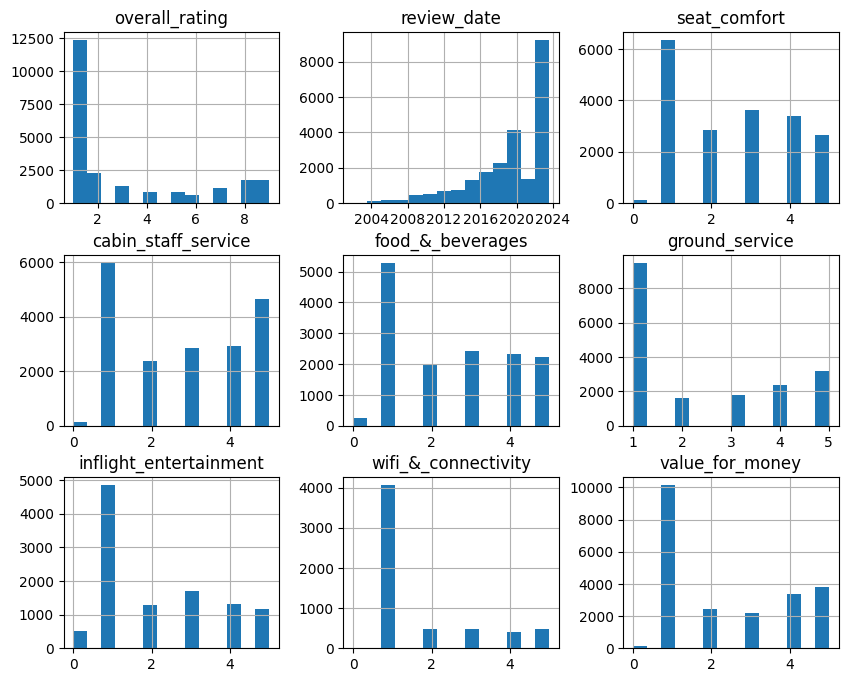

In [22]:
df.hist(figsize=[10,8], bins=14)

Vemos que hay una gran cantidad de reseñas fueron hechas en los ultimos años, y que hay muchas reseñas de 1 estrella en varias de las categorias.
La categoria de Staff y servicio de cabina es la que mas califcaciones positivas posee.

<Axes: title={'center': 'Distribucion de calificaciones totales'}, xlabel='overall_rating', ylabel='count'>

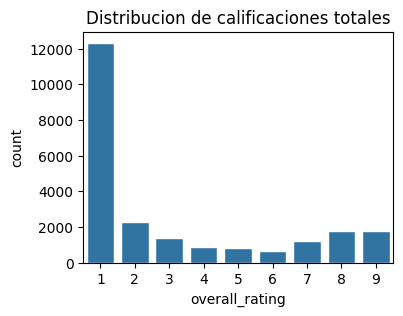

In [23]:
#Distribucion de calificaciones
plt.figure(figsize=(4,3))
plt.title("Distribucion de calificaciones totales")
sns.set_style("darkgrid")
sns.countplot(df,x='overall_rating')

<Axes: title={'center': 'Calificacion de precio-calidad por calificacion total'}, xlabel='overall_rating', ylabel='value_for_money'>

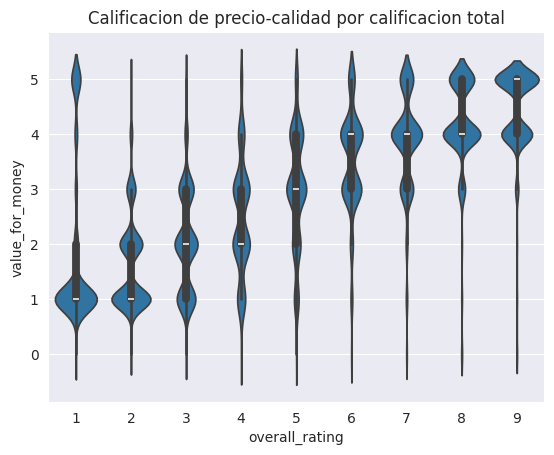

In [24]:
plt.title("Calificacion de precio-calidad por calificacion total")
sns.set_style("darkgrid")
sns.violinplot(df, x='overall_rating', y='value_for_money')

Observamos correlación en que a mayor calificacion relacion calidad-precio, mayor calificacion total. Hay una tendencia clara.

<Axes: title={'center': 'Distribucion de recomienda si/no'}, xlabel='recommended', ylabel='count'>

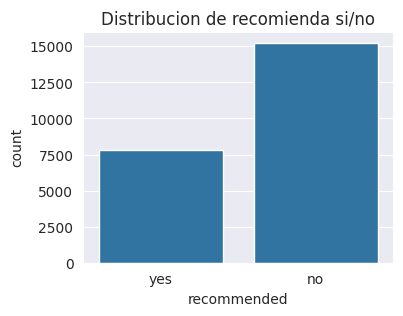

In [25]:
#Distribucion de recommended
plt.figure(figsize=(4,3))
plt.title("Distribucion de recomienda si/no")
sns.set_style("darkgrid")
sns.countplot(df,x='recommended')

In [26]:
# Conversion de la columna Recommended de Yes/no a 1 y 0 respectivamente
df["recommended"] = df["recommended"].map(dict(yes=1, no=0))
print(df[["recommended"]].to_string())

       recommended
0                1
1                0
2                0
3                0
4                0
5                0
6                0
7                0
8                0
9                1
10               0
11               0
12               0
13               0
14               0
15               1
16               0
17               0
18               1
19               0
20               0
21               1
22               1
23               1
24               1
25               0
26               0
27               0
28               0
29               1
30               0
31               1
32               1
33               1
34               1
35               0
36               0
37               1
38               1
39               0
40               1
41               1
42               1
43               1
44               1
45               1
46               0
47               1
48               1
49               1
50               1
51          

In [27]:
# Selección de columnas numéricas y de texto

df_num = df[["overall_rating", "review_date", "verified",
"seat_comfort", "cabin_staff_service", "food_&_beverages",
"ground_service", "inflight_entertainment", "wifi_&_connectivity", "value_for_money", "recommended"]]

df_text = df[["review", "type_of_traveller", "seat_type"]]

In [28]:
print(df.columns)

Index(['airline_name', 'overall_rating', 'review_title', 'review_date',
       'verified', 'review', 'type_of_traveller', 'seat_type', 'seat_comfort',
       'cabin_staff_service', 'food_&_beverages', 'ground_service',
       'inflight_entertainment', 'wifi_&_connectivity', 'value_for_money',
       'recommended'],
      dtype='object')


In [29]:
df['airline_name'].value_counts().reset_index()

,airline_name,count
0,Aegean Airlines,100
1,Aer Lingus,100
2,Norwegian,100
3,Oman Air,100
4,Onur Air,100
...,...,...
492,TUIfly Nordic,1
493,Air Labrador,1
494,Air Costa,1
495,Air Cote d'Ivoire,1


In [30]:
# Recuento de cantidad de reviews por aerolinea
df['airline_review_count'] = df.groupby('airline_name')['airline_name'].transform('count')
df[['airline_name', 'airline_review_count']].drop_duplicates().sort_values('airline_review_count', ascending=False)

,airline_name,airline_review_count
94,Aegean Airlines,100
194,Aer Lingus,100
15209,Norwegian,100
15426,Oman Air,100
15537,Onur Air,100
...,...,...
21076,TUIfly Nordic,1
2077,Air Labrador,1
1481,Air Costa,1
1482,Air Cote d'Ivoire,1


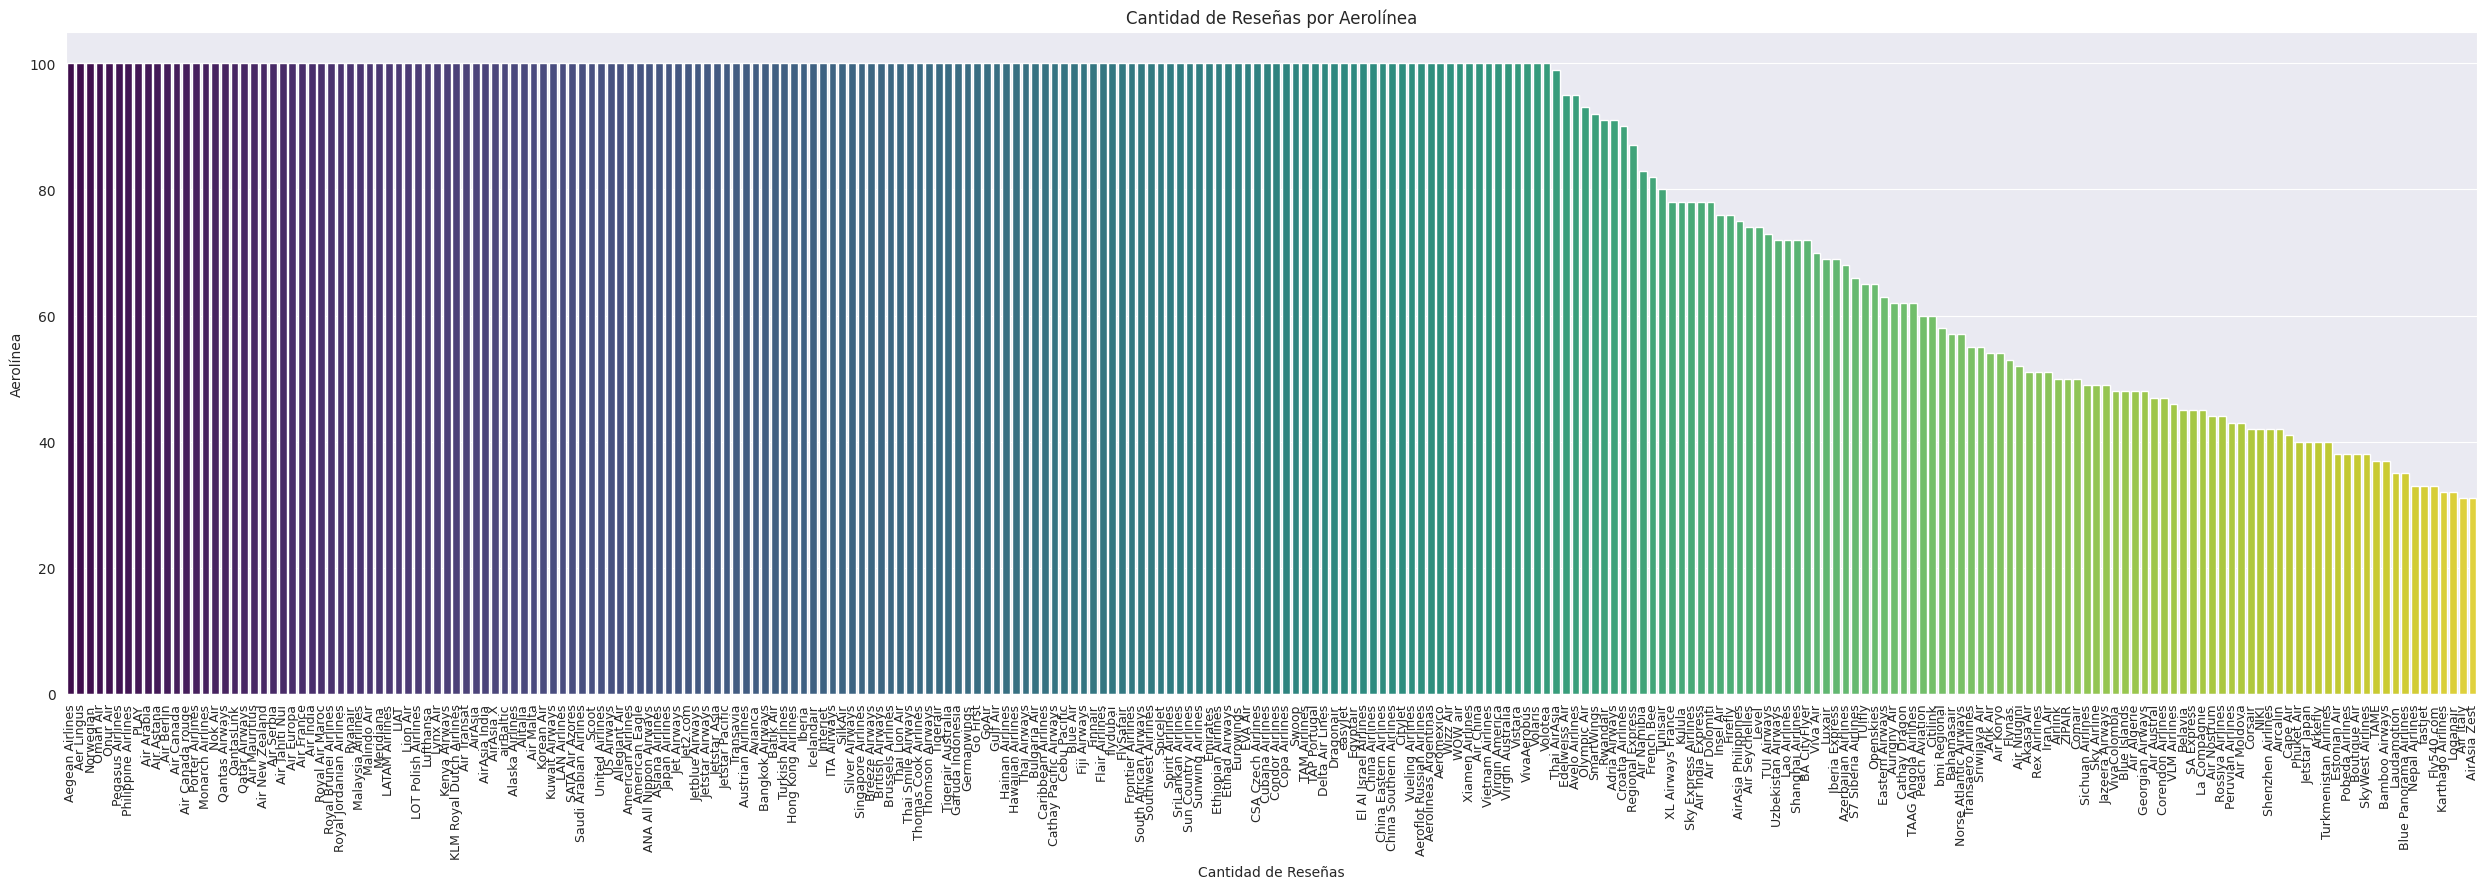

In [31]:
# Visualizacion del recuento de reviews por aerolinea (top 250)

df_airlines = df['airline_name'].value_counts().head(250).reset_index()
df_airlines.columns = ['airline_name', 'airline_review_count']

plt.figure(figsize=(25, 9))
sns.barplot(data=df_airlines, y='airline_review_count', x='airline_name', palette='viridis', hue='airline_name', legend=False)
plt.xticks(rotation=90, fontsize=9)

plt.title('Cantidad de Reseñas por Aerolínea')
plt.xlabel('Cantidad de Reseñas')
plt.ylabel('Aerolínea')
plt.tight_layout()
plt.show()

Vemos que las primeras 150 aerolineas poseen 100 reseñas cada una,, y luego va en disminución.

In [32]:
df_name_rev_count = df.groupby("airline_name").mean(numeric_only=True).drop(columns=["airline_review_count"]).reset_index()
df_name_rev_count

,airline_name,overall_rating,verified,seat_comfort,cabin_staff_service,food_&_beverages,ground_service,inflight_entertainment,wifi_&_connectivity,value_for_money,recommended
0,AB Aviation,3.666667,1.000000,2.666667,2.666667,2.000000,2.000000,NaN,NaN,2.333333,0.333333
1,ANA All Nippon Airways,3.750000,0.840000,4.281250,4.604167,4.177778,4.193878,3.988235,4.125000,4.110000,0.780000
2,ASKY Airlines,2.304348,0.391304,2.142857,1.857143,1.941176,1.555556,1.090909,1.000000,1.565217,0.130435
3,ATA Airlines,1.500000,0.000000,1.000000,1.500000,1.500000,1.500000,NaN,NaN,2.000000,0.000000
4,Adria Airways,4.087912,0.131868,3.392857,3.428571,2.627907,3.051282,1.718750,1.900000,2.942857,0.472527
...,...,...,...,...,...,...,...,...,...,...,...
492,euroAtlantic Airways,2.062500,0.562500,1.375000,1.875000,2.307692,1.625000,1.538462,1.666667,1.437500,0.125000
493,fastjet,2.878788,0.363636,3.000000,2.928571,2.125000,2.290323,1.285714,1.000000,2.272727,0.303030
494,flyadeal,1.894737,0.842105,1.600000,1.666667,1.857143,1.333333,1.000000,1.000000,1.736842,0.052632
495,flybe,1.250000,1.000000,3.333333,4.333333,4.500000,3.500000,NaN,NaN,3.250000,0.500000


In [33]:
# merge de los dos dataframes con el recuento de aerolineas y los ratings
df_summ = pd.merge(
    df_airlines,
    df_name_rev_count,
    how="inner",
    on='airline_name')
df_summ.head()

,airline_name,airline_review_count,overall_rating,verified,seat_comfort,cabin_staff_service,food_&_beverages,ground_service,inflight_entertainment,wifi_&_connectivity,value_for_money,recommended
0,Aegean Airlines,100,3.02,0.80,2.806452,3.225806,2.822785,2.606383,2.515152,2.666667,2.49,0.34
1,Aer Lingus,100,2.18,0.58,2.255319,2.500000,1.910256,1.842105,2.131148,1.625000,1.90,0.13
2,Norwegian,100,2.43,0.81,2.696203,2.848101,2.420000,2.392857,2.536585,2.750000,2.38,0.32
3,Oman Air,100,2.89,0.82,3.396825,3.333333,3.186441,3.046875,3.277778,1.950000,2.45,0.35
4,Onur Air,100,3.65,0.09,1.982143,2.125000,1.698113,1.352941,0.812500,1.000000,2.84,0.37


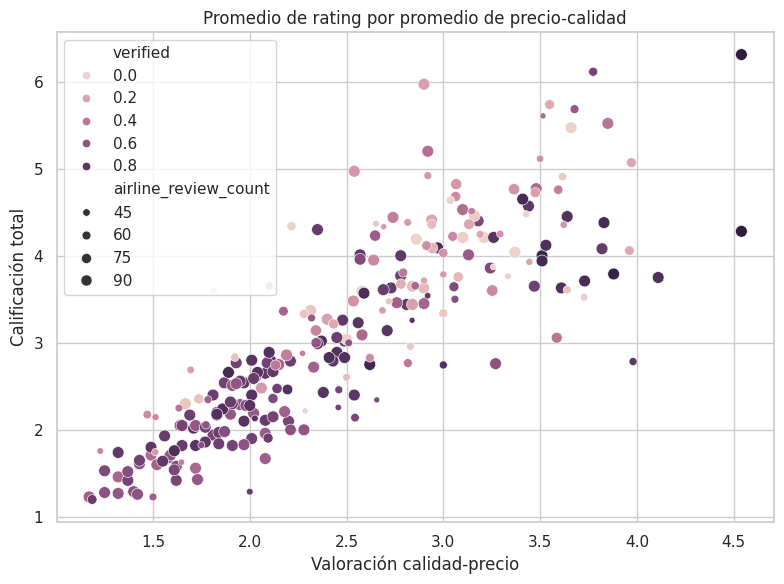

In [34]:
# Visualización de los ratings y la calificacion de precio-calidad
sns.set_theme(style="whitegrid")
plt.subplots(figsize=(8,6))
sns.scatterplot(df_summ, x="value_for_money", y="overall_rating",
                 size='airline_review_count', hue='verified')
plt.title("Promedio de rating por promedio de precio-calidad")
plt.xlabel('Valoración calidad-precio')
plt.ylabel('Calificación total')
plt.tight_layout()
plt.show()

Vemos en mayor detalle la correlación que existe entre la calificacion promedio de cada aerolinea y el promedio de calificacion calidad-precio.
La cantidad de reseñas se puede ver con el tamaño de cada circulo y el color indica cuantas de esas reseñas estan verificadas por el sitio.

<Axes: title={'center': 'Calificacion de precio-calidad por calificacion total'}, xlabel='recommended', ylabel='overall_rating'>

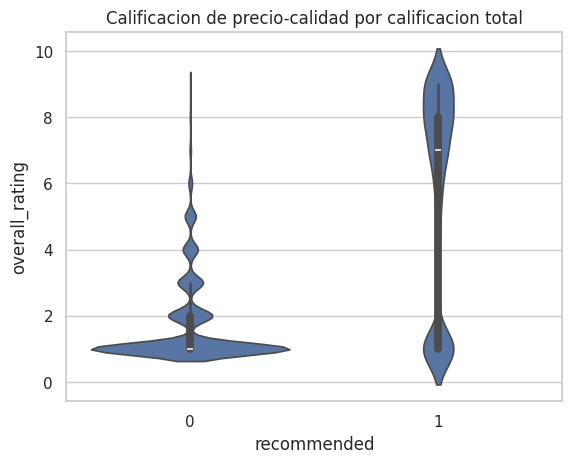

In [35]:
plt.title("Calificacion de precio-calidad por calificacion total")
sns.set_style("darkgrid")
sns.violinplot(df, y='overall_rating', x='recommended')

Vemos tambien una relacion entre la calificacion total y la recomendacion o no recomendacion de la aerolinea

In [36]:
df_num = df_num.drop(columns=["review_date"])
print(df_num.columns)
print(df_num.columns.names)

Index(['overall_rating', 'verified', 'seat_comfort', 'cabin_staff_service',
       'food_&_beverages', 'ground_service', 'inflight_entertainment',
       'wifi_&_connectivity', 'value_for_money', 'recommended'],
      dtype='object')
[None]


<Axes: >

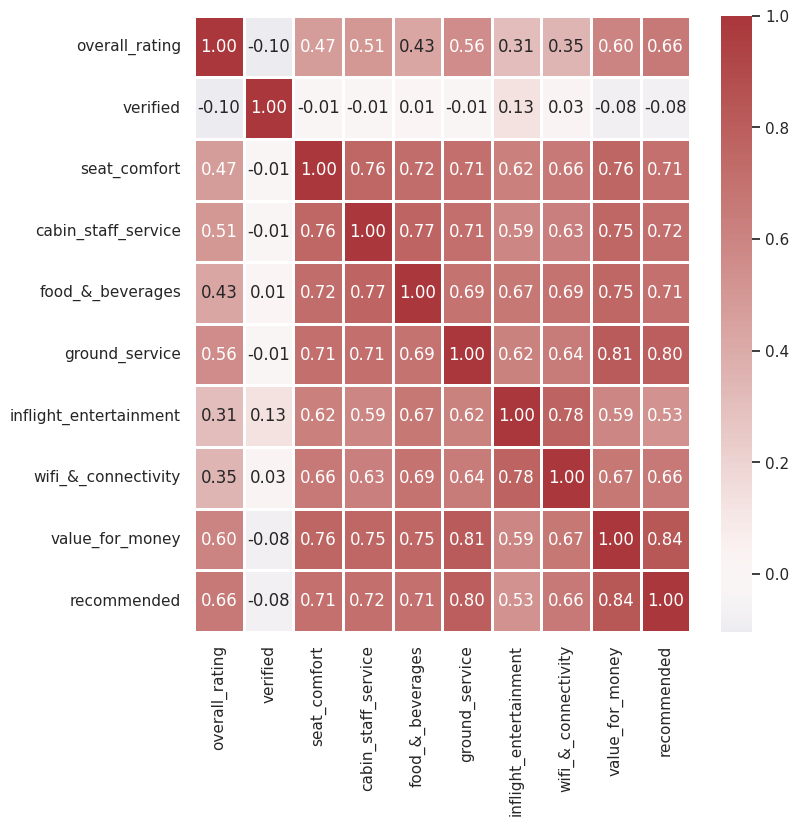

In [37]:
corr = df_num.corr()

used_columns = df_num.columns[df_num.columns.isin(corr.columns)]

df_corr = df_num[used_columns]
corr_matrix = df_corr.corr()

# Graficar con números
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=.75)


Vemos en la matriz de correlaciones que la mayor correlacion se puede encontrar entre value_for_money (precio-calidad), y recommended. Tambien entre otras calificaciones de servicio en aeropuerto y value_for_money.

# **Análisis y preprocesamiento del Texto**

####**Longitud de las Oraciones**

In [38]:
print(df["review"].dropna().iloc[0])

  Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time.


In [39]:
df["review"] = df["review"].fillna("")

def longitud_oraciones(text):
    try:
        oraciones = sent_tokenize(text)
        if not oraciones:
            return pd.Series([0, 0])
        len_oraciones = [len(word_tokenize(sent)) for sent in oraciones]
        return pd.Series([len(oraciones), sum(len_oraciones) / len(len_oraciones)])
    except:
        return pd.Series([0, 0])

# Aplicamos la función a cada review
df[["num_sentences", "avg_sentence_length"]] = df["review"].apply(longitud_oraciones)

In [40]:
#Vemos la cantidad de oraciones en cada review
df[["num_sentences"]]

,num_sentences
0,5.0
1,12.0
2,6.0
3,10.0
4,5.0
...,...
23166,8.0
23167,9.0
23168,6.0
23169,36.0


In [41]:
#Promedio de oraciones en las reviews
df[["num_sentences"]].mean()

,0
num_sentences,8.388183


In [42]:
# Promedio de largo de cada oracion (en palabras)
df['avg_sentence_length']

,avg_sentence_length
0,14.600000
1,12.416667
2,12.833333
3,14.200000
4,26.000000
...,...
23166,20.375000
23167,17.888889
23168,29.666667
23169,18.583333


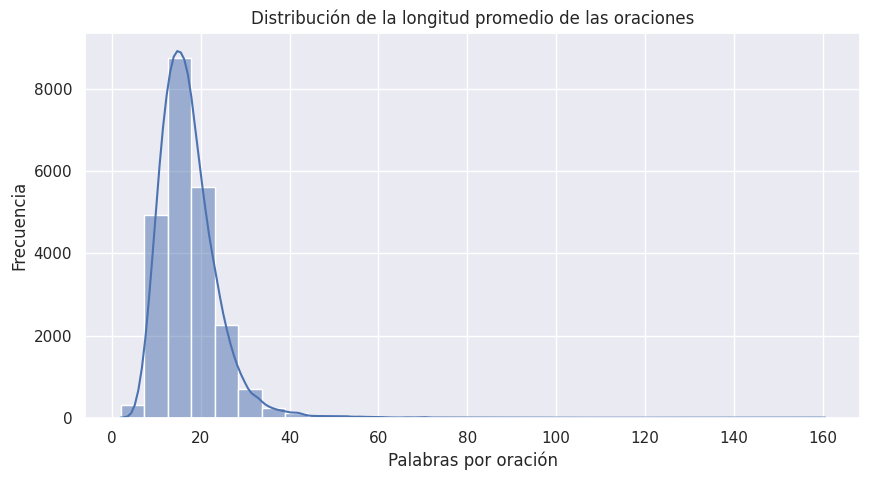

In [43]:
plt.figure(figsize=(10, 5))
sns.histplot(df["avg_sentence_length"], bins=30, kde=True)
plt.title("Distribución de la longitud promedio de las oraciones")
plt.xlabel("Palabras por oración")
plt.ylabel("Frecuencia")
plt.show()

Vemos que la moda se encuentra entre las 15 y 20 palabras por oración.

####**Frecuencia de Palabras**

In [44]:
# Se concatena todas las reviews en un texto

text = " ".join(df["review"].dropna().astype(str))

# Tokenizar
tokens = word_tokenize(text.lower())  # pasar a minusculas

# Quitar puntuaciones, numeros y stopwords
stop_words = set(stopwords.words("english"))
tokens_cleaned = [
    word for word in tokens
    if word.isalpha() and word not in stop_words
    ]

In [45]:
# Contar frecuencia
freq_palabras = Counter(tokens_cleaned)

top_palabras = freq_palabras.most_common(40)

print(top_palabras)

[('flight', 42353), ('airline', 12761), ('service', 12697), ('time', 12305), ('us', 9495), ('would', 9413), ('one', 8499), ('airport', 8465), ('staff', 8382), ('hours', 7912), ('flights', 7564), ('get', 7509), ('plane', 7204), ('seats', 6862), ('good', 6850), ('crew', 6799), ('air', 6676), ('seat', 6525), ('food', 6430), ('even', 6413), ('airlines', 6123), ('could', 5875), ('back', 5813), ('fly', 5754), ('told', 5751), ('luggage', 5643), ('customer', 5539), ('check', 5455), ('never', 5274), ('experience', 5254), ('cabin', 5230), ('boarding', 5080), ('passengers', 4916), ('hour', 4806), ('delayed', 4627), ('first', 4576), ('got', 4422), ('ticket', 4368), ('return', 4198), ('another', 4081)]


<ipython-input-46-fc96ff5faf99>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_frec, x="frequency", y="word", palette="Blues_d")


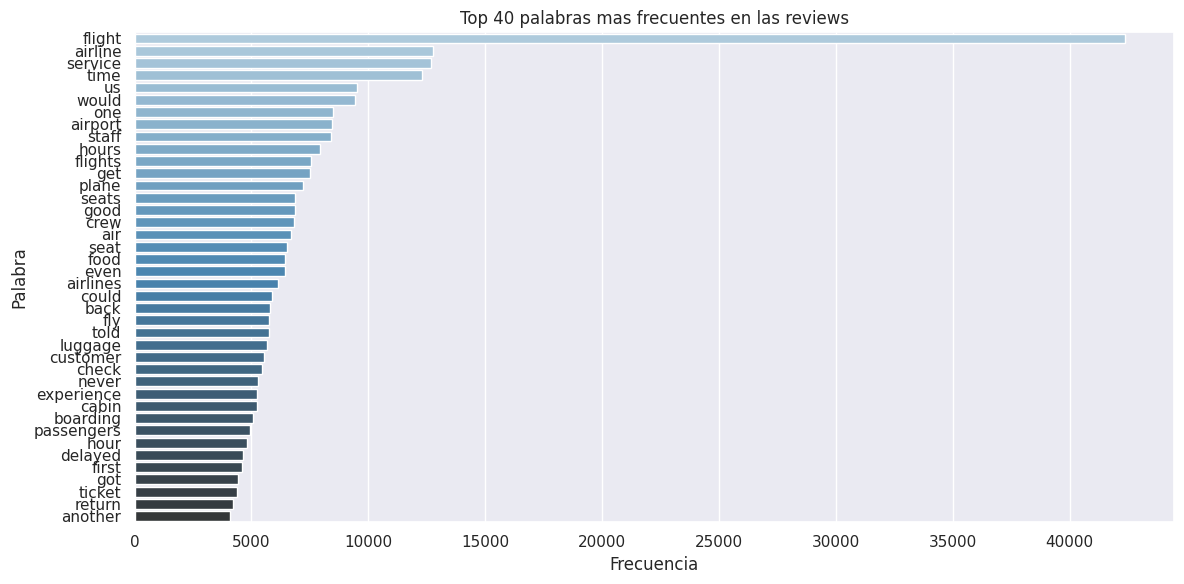

In [46]:
# se convierte la frecuencia de las palabras a un DF para graficar
df_frec = pd.DataFrame(top_palabras, columns=["word", "frequency"])

plt.figure(figsize=(12, 6))
sns.barplot(data=df_frec, x="frequency", y="word", palette="Blues_d")
plt.title("Top 40 palabras mas frecuentes en las reviews")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.tight_layout()
plt.show()

Vemos el top de palabras mas usadas: **Flight, airline, service y time** de las mas comunes entendiblemente. Luego hay algunas interesantes, **hours**, **never, delayed, return, another** , que parece que se refieren a los problemas que son explayados en las reviews.

####**Partes del Discurso (POS)**

In [47]:
tagged_tokens = pos_tag(tokens)
# Agrupar por tipo
pos_counts = Counter(tag for word, tag in tagged_tokens)

print(pos_counts.most_common(20))

[('NN', 636770), ('IN', 340343), ('DT', 283332), ('JJ', 253360), ('VBD', 197265), ('RB', 194072), ('.', 190288), ('VB', 152151), ('PRP', 138579), ('NNS', 135409), ('CC', 119151), ('TO', 109006), (',', 80546), ('VBN', 76251), ('CD', 64572), ('VBP', 62513), ('PRP$', 57217), ('VBG', 57099), ('VBZ', 43158), ('MD', 34177)]


<ipython-input-48-08409d68123a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, x="Count", y="POS", palette="viridis")


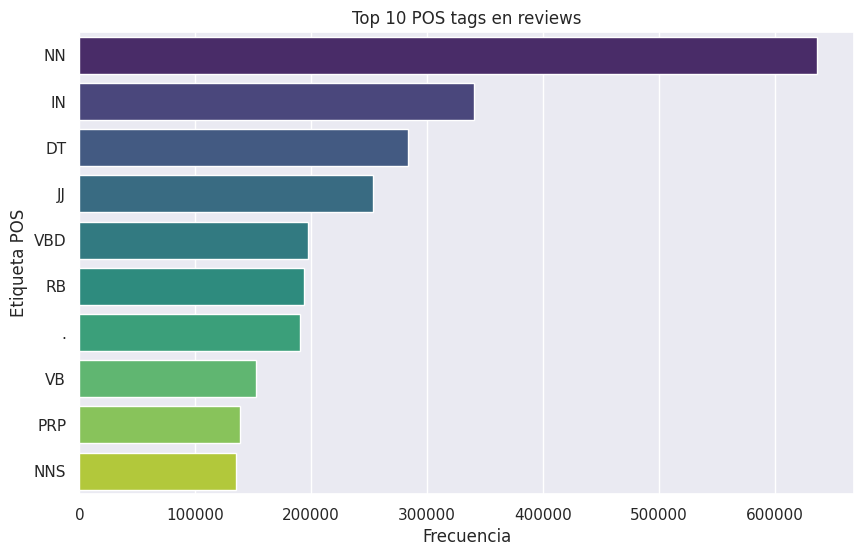

In [48]:
pos_df = pd.DataFrame(pos_counts.items(), columns=["POS", "Count"])
pos_df = pos_df.sort_values(by="Count", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=pos_df, x="Count", y="POS", palette="viridis")
plt.title("Top 10 POS tags en reviews")
plt.xlabel("Frecuencia")
plt.ylabel("Etiqueta POS")
plt.show()

Vemos que los tipos de palabras mas comunes son los sustantivos en primer lugar, luego los articulos o preposiciones, luego los adjetivos y luego los verbos en pasado.

####**Distribución de Longitud de Palabras**

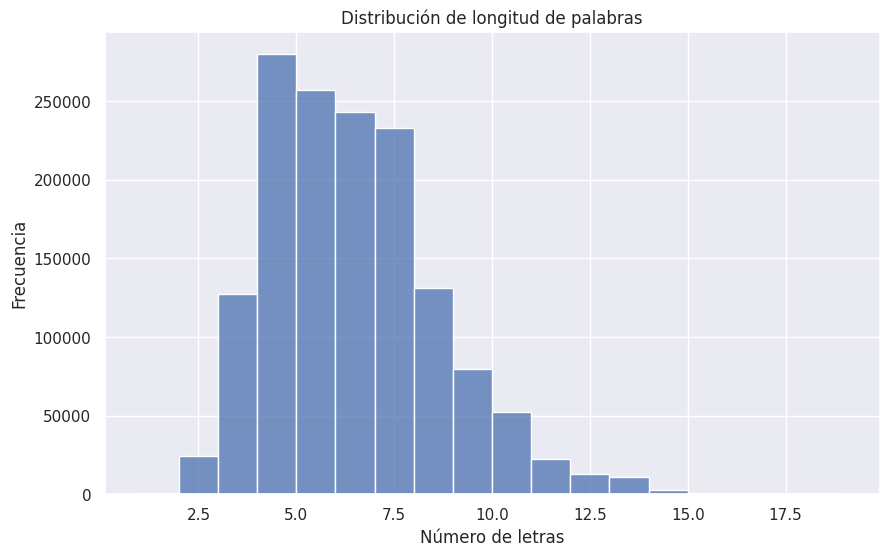

In [49]:
word_lengths = [len(word) for word in tokens_cleaned]

plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, bins=range(1, 20), kde=False)
plt.title("Distribución de longitud de palabras")
plt.xlabel("Número de letras")
plt.ylabel("Frecuencia")
plt.show()

####**Análisis de N-gramas**

In [50]:
# Bigramas
bigramas = list(ngrams(tokens_cleaned, 2))
bigramas_freq = Counter(bigramas).most_common(20)

# Trigramas
trigramas = list(ngrams(tokens_cleaned, 3))
trigramas_freq = Counter(trigramas).most_common(20)

print("Top 10 Bigramas:")
for par in bigramas_freq[:10]:
    print(par)

print("\nTop 10 Trigramas:")
for trio in trigramas_freq[:10]:
    print(trio)


Top 10 Bigramas:
(('customer', 'service'), 3984)
(('cabin', 'crew'), 2463)
(('business', 'class'), 2294)
(('flight', 'delayed'), 1664)
(('return', 'flight'), 1434)
(('flight', 'attendants'), 1304)
(('even', 'though'), 1034)
(('connecting', 'flight'), 1030)
(('flight', 'cancelled'), 1006)
(('never', 'fly'), 968)

Top 10 Trigramas:
(('worst', 'airline', 'ever'), 462)
(('flight', 'delayed', 'hours'), 339)
(('worst', 'customer', 'service'), 214)
(('cabin', 'crew', 'friendly'), 209)
(('worst', 'experience', 'ever'), 204)
(('never', 'fly', 'airline'), 187)
(('first', 'time', 'flying'), 180)
(('ho', 'chi', 'minh'), 175)
(('flight', 'next', 'day'), 160)
(('low', 'cost', 'airline'), 153)


Aquí podemos ver los bigramas y trigamas que mas frecuencia tienen en las reviews.

Notamos que en este caso los bigramas mas comunes suelen ser sustantivos, y los trigramas mas comunes suelen ser descriptivos de la experiencia (por lo visto mayormente negativas).

####**Análisis de la Diversidad Léxica**

La diversidad lexica seria la cantidad de palabras unicas dividido la cantidad de palabras totales, para analizar que tan variado es el vocabulario, o si suelen ser palabras comunes y repetidas.

In [51]:
palabras_totales = len(tokens_cleaned)
palabras_unicas = len(set(tokens_cleaned))
diversidad_lexica = palabras_unicas / palabras_totales

print(f"Diversidad léxica: {diversidad_lexica:.3f}")

Diversidad léxica: 0.020


La diversidad de 0.020 es muy baja, por lo que suelen ser palabras comunes y repetidas.

A partir de un valor de 0.3 suele ser mas variado, y de mas de 0.7 es muy variado.

####**Visualización de Palabras con Word Cloud**

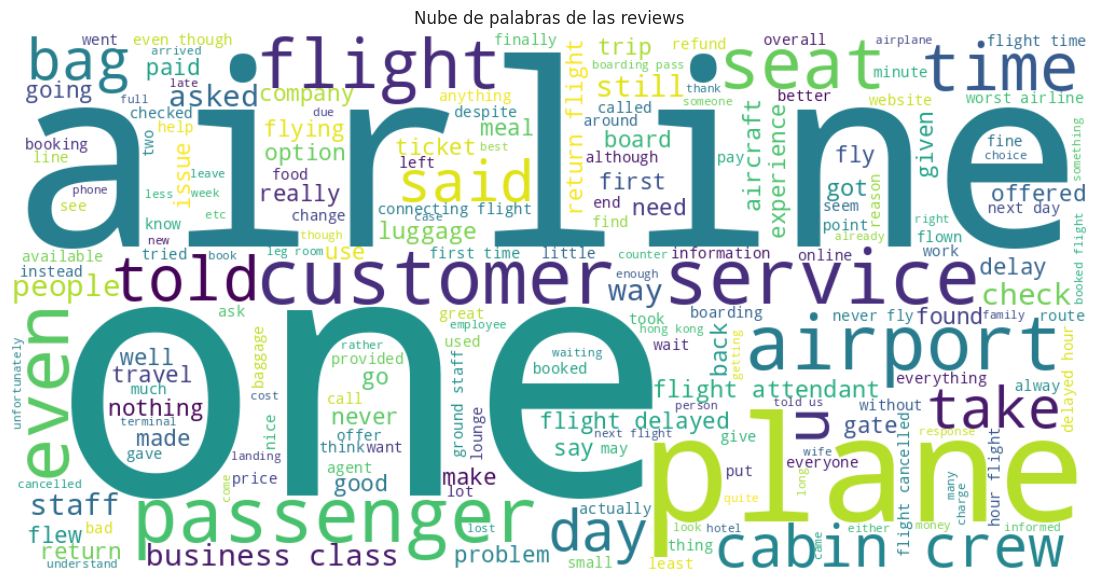

In [52]:
wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(" ".join(tokens_cleaned))

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras de las reviews")
plt.show()

####**Conclusiones del Analisis exploratorio**

Podemos concluir a partir de este analisis, lo siguiente

*   La longitud promedio de las oraciones de las reviews ronda entre **15 y 20 palabras.**
*   Un promedio de 8.33 oraciones por review.

*   Hay bastantes palabras utilizadas muchas veces, pero pocas utilizadas muchisimas veces: ('flight', 42353), ('airline', 12761), ('service', 12697), ('time', 12305).
*   Los **bigramas** mas utilizados, son menciones: (('customer', 'service'), 3984)
(('cabin', 'crew'), 2463)
(('business', 'class'), 2294)


*   Y los **trigramas** mas utilziados son mas descriptivos: (('worst', 'airline','ever'), 462)
(('flight', 'delayed', 'hours'), 339)
(('worst', 'customer', 'service'), 214)
(('cabin', 'crew', 'friendly'), 209)

    Estos muestran aspectos clave que los pasajeros valoran o critican.



*   Se pueden ver temas recurrentes, las reviews se centran mayormente en servicio, comodidad y puntualidad.

### **Análisis Sintáctico**

Podemos ver las relaciones sintacticas en las frases, el tipo de palabra y su relacion con otras.

In [53]:
review = df['review'].iloc[422]
doc = nlp(review)

# Mostrar estructura de las frases
for token in doc:
    print(f"{token.text:<15} {token.pos_:<10} {token.dep_:<15} {token.head.text}")

                SPACE      dep             Horrible
Horrible        ADJ        amod            service
service         NOUN       nsubj           supposed
,               PUNCT      punct           service
flight          NOUN       appos           service
from            ADP        prep            flight
Buenos          PROPN      compound        Aires
Aires           PROPN      pobj            from
to              ADP        prep            flight
Rio             PROPN      compound        Janeiro
de              PROPN      compound        Janeiro
Janeiro         PROPN      pobj            to
supposed        VERB       ROOT            supposed
to              PART       aux             depart
depart          VERB       xcomp           supposed
at              ADP        prep            depart
18:20           NUM        pobj            at
on              ADP        prep            depart
the             DET        det             31st
31st            NOUN       pobj            on
May 

###**Análisis Semántico**

Por ejemplo de una review positiva:

In [54]:
print(df["review"].iloc[0])

  Moroni to Moheli. Turned out to be a pretty decent airline. Online booking worked well, checkin and boarding was fine and the plane looked well maintained. Its a very short flight - just 20 minutes or so so i didn't expect much but they still managed to hand our a bottle of water and some biscuits which i though was very nice. Both flights on time.


In [55]:
review_pos = df['review'].iloc[0]
blob = TextBlob(review_pos)
print(f"Polaridad: {blob.sentiment.polarity}, Subjetividad: {blob.sentiment.subjectivity}")

Polaridad: 0.3022222222222222, Subjetividad: 0.6261111111111112


La polaridad (de -1.0 a +1.0) indica que tan negativa (-1.0) o positiva (+1.0) es. Y la subjetividad (de 0 a 1) indica la objetividad (0.0) a subjetividad (1.0)

Un ejemplo de review negativa:

In [56]:
print(df["review"].iloc[18293])

  Horrible Customer Service! I booked extra luggage by accident and I wanted to cancel it. I called 5 times and was on hold for forever to get someone to speak too. I asked about a refund and they just said there is nothing they can do. Flight: old propeller plane, uncomfortable seats and the flight attendants didn’t assure Covid safety on board. They looked away to not see people take off their masks. And the flight was delayed also!


In [57]:
review_neg = df['review'].iloc[18293]
blob = TextBlob(review_neg)
print(f"Polaridad: {blob.sentiment.polarity}, Subjetividad: {blob.sentiment.subjectivity}")

Polaridad: -0.38125, Subjetividad: 0.575


En este caso la review siendo la review negativa da una polaridad de -0.38.

###**Codificación de texto a vectores**

####Tf-IDF

In [58]:
reviews = df['review'].dropna().astype(str)

# Tokenizer para mantener palabras alfabeticas
def clean_tokenizer(text):
    return re.findall(r'\b[a-zA-Z]{2,}\b', text.lower())

# se instancia el TF-IDF
tfidf = TfidfVectorizer(tokenizer=clean_tokenizer, stop_words='english', max_df=0.95, min_df=5)

# se aplica al corpus
X_tfidf = tfidf.fit_transform(reviews)

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

print(tfidf_df.head())

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


    aa        ab  ababa  aback  abandon  abandoned  abbotsford  aber  \
0  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   
1  0.0  0.255136    0.0    0.0      0.0        0.0         0.0   0.0   
2  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   
3  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   
4  0.0  0.000000    0.0    0.0      0.0        0.0         0.0   0.0   

   aberdeen  abide  ...  zim  zimbabwe  zip  zipair  zone  zones  zoo  zrh  \
0       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
1       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
2       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
3       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   
4       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0    0.0  0.0  0.0   

    zu  zurich  
0  0.0     0.0  
1  0.0     0.0  
2  0.0     0.0  
3  0.0     0.0  
4  0.0     0.

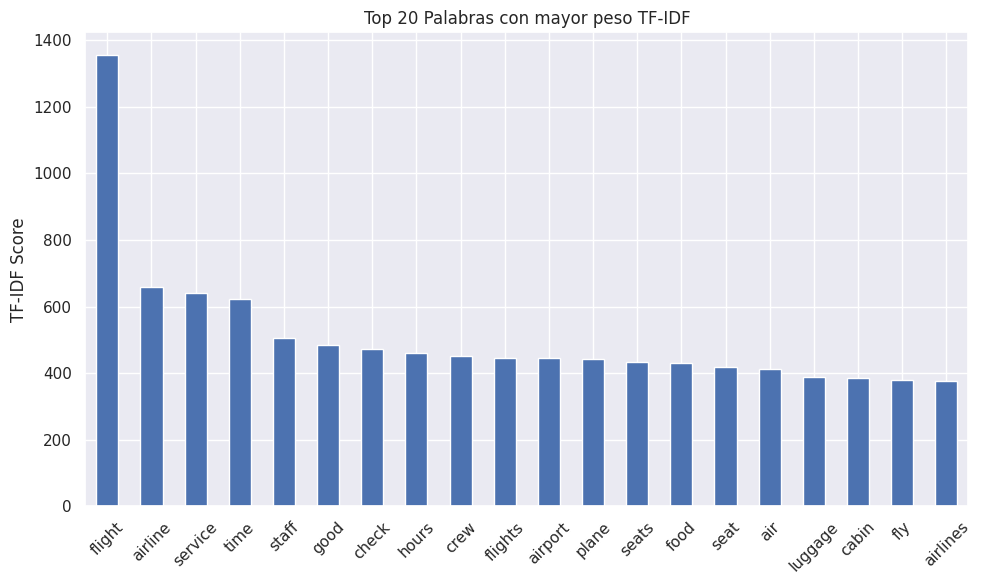

In [59]:
# Puntajes TF-IDF por palabra en todo el corpus
puntajes_tf = tfidf_df.sum().sort_values(ascending=False)


plt.figure(figsize=(10, 6))
puntajes_tf.head(20).plot(kind='bar')
plt.title("Top 20 Palabras con mayor peso TF-IDF")
plt.ylabel("TF-IDF Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

El TF-IDF evalua el peso de las palabras en el contexto en el que están. Muchas son coincidentes con las palabras mas utilziadas

####Word Embendings

#**Feature Selection**

**Selección de variable objetivo y variables independientes**

Utilizando Overall_rating como variable target. En primera instancia probaría como positivo un valor mayor de 5, y negativo como menor que 5 inclusive.

In [60]:
df = df.dropna(subset=['review', 'overall_rating'])
df['overall_rating'] = df['overall_rating'].astype(float)
#Se define la calificacion a binario
df['label'] = df['overall_rating'].apply(lambda x: 1 if x >= 5 else 0)

# variables x
X = tfidf.fit_transform(df['review'])

# target
y = df['label']

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [61]:
df['label'].value_counts()

,count
label,
0,16836
1,6215


La cantidad de reviews negativas quedo en 16836 y la cantidad de positivas en 6215. Un desbalance que puede afectar al modelo.

# **Modelos**

**División de datos en conjuntos de entrenamiento y prueba**

In [62]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Balanceo de clases

Al tener una diferencia tan grande entre reviews positivas y negativas hay que hacer un resampling para balancear la cantidad de reviews positivas y negativas, asi el modelo se entrena correctamente.

In [63]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [64]:
Counter(y_resampled)

Counter({0: 13485, 1: 13485})

Vemos ahora que las variables target tienen la misma cantidad de valores 0 y 1

##Regresion Logistica

In [65]:
# Regresion logistica
clf = LogisticRegression(C=1, class_weight='balanced')
clf.fit(X_resampled, y_resampled)

LogisticRegression(C=1, class_weight='balanced')

**Evaluación del rendimiento del modelo**

In [66]:
# Evaluación
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3351
           1       0.66      0.78      0.72      1260

    accuracy                           0.83      4611
   macro avg       0.79      0.82      0.80      4611
weighted avg       0.84      0.83      0.84      4611



**Predicción con conjunto de prueba**

In [67]:
review_nueva = ["The flight was comfortable and the staff were very friendly."]

# Convertir la review a vector
X_new = tfidf.transform(review_nueva)

# Prediccion
prediction = clf.predict(X_new)
proba = clf.predict_proba(X_new)

print("Predicción:", "Positiva" if prediction[0] == 1 else "Negativa")
print("Probabilidad:", proba[0])

Predicción: Positiva
Probabilidad: [0.03674529 0.96325471]


Vemos que la predicción dio una probabilidad de 0.03 de que sea negativa, y una probabilidad de 0.96 de que sea positiva.

In [68]:
test_reviews = [
    "The flight was delayed and the food was terrible.",
    "Fantastic service and very smooth check-in process.",
    "Seats were okay, nothing special.",
    "Terrible flight, rude staff, and broken seats.",
    "One of the best flights I’ve had in years!"
]

# Transformar con el mismo vectorizador TF-IDF
X_test_reviews = tfidf.transform(test_reviews)

# Obtener predicciones y probabilidades
predictions = clf.predict(X_test_reviews)
probabilities = clf.predict_proba(X_test_reviews)

# Mostrar resultados
for review, pred, proba in zip(test_reviews, predictions, probabilities):
    sentiment = "Positiva" if pred == 1 else "Negativa"
    confidence = proba[1] if pred == 1 else proba[0]

    print(f"📝 Review: {review}")
    print(f"🔮 Predicción: {sentiment} (Confianza: {confidence:.2f})")
    print("-" * 60)

📝 Review: The flight was delayed and the food was terrible.
🔮 Predicción: Negativa (Confianza: 0.96)
------------------------------------------------------------
📝 Review: Fantastic service and very smooth check-in process.
🔮 Predicción: Positiva (Confianza: 0.56)
------------------------------------------------------------
📝 Review: Seats were okay, nothing special.
🔮 Predicción: Positiva (Confianza: 0.85)
------------------------------------------------------------
📝 Review: Terrible flight, rude staff, and broken seats.
🔮 Predicción: Negativa (Confianza: 1.00)
------------------------------------------------------------
📝 Review: One of the best flights I’ve had in years!
🔮 Predicción: Negativa (Confianza: 0.70)
------------------------------------------------------------


**Conclusión sobre el modelado y las metricas**

La regresión logistica dio un resultado bastante aceptable en primera instancia, con una precisión, 0.8 aprox
Pero con un recall bajo (58%), el modelo no identifica bien las reviews positivas.

F1-score general: aceptable, pero mejorable.

##Random Forest Classifier

In [69]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [70]:
# Evaluación
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      3351
           1       0.65      0.71      0.68      1260

    accuracy                           0.82      4611
   macro avg       0.77      0.78      0.78      4611
weighted avg       0.82      0.82      0.82      4611



In [71]:
review_nueva = ["The flight was comfortable and the staff were very friendly."]

# Convertir la review a vector
X_new = tfidf.transform(review_nueva)

# Prediccion
prediction = rf_clf.predict(X_new)
proba = rf_clf.predict_proba(X_new)

print("Predicción:", "Positiva" if prediction[0] == 1 else "Negativa")
print("Probabilidad:", proba[0])

Predicción: Positiva
Probabilidad: [0.39 0.61]


##XGBoost + TF-IDF

In [72]:
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

In [73]:
# Grid de parametros

neg = len(y[y == 0])
pos = len(y[y == 1])

param_grid_xgb = {
    'n_estimators': [100, 150],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'use_label_encoder': [True],
    'scale_pos_weight': [neg / pos]
}

# Crear GridSearch
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    n_jobs=-1,
    cv=3,
    verbose=2
)

# Entrenamiento
grid_xgb.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:39:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1], 'learning_rate': [0.1, 0.2],
                         'max_depth': [3, 6], 'n_estimators': [100, 150],
                         'scale_pos_weight': [2.7089300080450522],
                         'subsample': [1], 'use_label_encoder': [True]},
             scoring='f1', verbose=2)

In [74]:
print("Mejores parámetros:", grid_xgb.best_params_)

best_model = grid_xgb.best_estimator_

# Evaluar
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Mejores parámetros: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'scale_pos_weight': 2.7089300080450522, 'subsample': 1, 'use_label_encoder': True}
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      3351
           1       0.58      0.83      0.68      1260

    accuracy                           0.79      4611
   macro avg       0.75      0.80      0.76      4611
weighted avg       0.83      0.79      0.80      4611



In [75]:
new_reviews = [
    "Amazing flight experience, very smooth and clean.",
    "Worst flight I've ever had, very rude staff."
]

X_new = tfidf.transform(new_reviews)
preds = best_model.predict(X_new)
probas = best_model.predict_proba(X_new)

for review, pred, proba in zip(new_reviews, preds, probas):
    label = "Positiva" if pred == 1 else "Negativa"
    print(f"📝 {review}")
    print(f"🔮 {label} (Confianza: {proba[pred]:.2f})\n")

📝 Amazing flight experience, very smooth and clean.
🔮 Negativa (Confianza: 0.50)

📝 Worst flight I've ever had, very rude staff.
🔮 Negativa (Confianza: 0.91)



##**Optimización de modelos**

In [76]:
#Optimizacion de Regresion logistica
clf_params = {
    'C': [0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

grid_clf = GridSearchCV(LogisticRegression(), clf_params, cv=5, scoring='f1',verbose=2)
grid_clf.fit(X_resampled, y_resampled)

print("Best params:", grid_clf.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.1s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.2s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.3s
[CV] END .............................C=1, class_weight=None; total time=   0.4s
[CV] END .............................C=1, class_

In [77]:
# Optimizacion de Random Forest
param_grid_rf = {
    'n_estimators': [100, 150],           # Cantidad de árboles
    'max_depth': [None, 10, 20],      # Profundidad máxima de los árboles
    'min_samples_split': [ 5, 10],      # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [2, 4],        # Mínimo de muestras en una hoja
    'max_features': ['sqrt'],     # Qué proporción de features usar
    'class_weight': [None, 'balanced']    # Para manejar el desbalance de clases
}


grid_search_rf = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1,           # Usa todos los núcleos disponibles
    scoring='f1',        # Métrica para evaluar el balance precisión/recall
    verbose=2
)
grid_search_rf.fit(X_resampled, y_resampled)

print("Mejores parámetros:", grid_search_rf.best_params_)
print("Mejor puntaje F1:", grid_search_rf.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Mejores parámetros: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Mejor puntaje F1: 0.8564561755090256


# **Conclusiones Finales**

Se puede predecir con cierta precisión el sentimiento de las nuevas reviews que van ingresando a las plataformas, con el fin de categorizarlas y obtener así un insight mayor, sobre la experiencia de usuario y los puntos clave que son valorados o criticados.

En el futuro se podría utilizar mas variables numéricas como value_for_money, ground_service, cabin_staff_service, seat_comfort, seat_comfort para darle mayor detalle y presicion al entrenamiento del modelo.